In [1]:
import torch
import numpy as np
import models
import data
import utils
from matplotlib import pyplot as plt

# Так как тесты проходят не валидационном датасете, а другом. Поэтому в данной части немного исправим файлы `predictions_run*`

In [3]:
"--dir=logs",
data_path="./data/"
dataset="CIFAR10"
transform="VGG"
model="VGG16"
batch_size=128
num_workers=4
use_test=False
"--save_freq=200",
"--print_freq=5",
"--epochs=200",
"--wd=0.001",
"--lr=0.05",
dropout=0.5
"--comment=width64",
"--seed=25477",
width=64
"--num-nets=8",
"--num-exps=5"

loaders, num_classes = data.loaders(dataset,
                                    data_path,
                                    batch_size,
                                    num_workers,
                                    transform,
                                    use_test
                                    )

architecture = getattr(models, model)()
architecture.kwargs["k"] = width
if "VGG" in model or "WideResNet" in model:
    architecture.kwargs["p"] = dropout
model = architecture.base(num_classes=num_classes, **architecture.kwargs)

Files already downloaded and verified
Using train (45000)
Using validation (5000)


In [7]:
def predictions(test_loader, model, **kwargs):
    model.eval()
    preds = []
    targets = []
    for input, target in test_loader:
        input = input.cuda() # async=True
        output = model(input, **kwargs)
        probs = output #F.softmax(output, dim=1)
        preds.append(probs.cpu().data.numpy())
        targets.append(target.numpy())
    return np.vstack(preds), np.concatenate(targets)

In [8]:
# work_dir = 'drive/MyDrive/Vetrov/power_laws_deep_ensembles/logs/oct/train.py-CIFAR10_VGG16/width16_bootstrapped_DS-11-16-22:42:00/'
work_dir = 'drive/MyDrive/Vetrov/power_laws_deep_ensembles/logs/oct/train.py-CIFAR10_VGG16/width16_all_DS-11-16-22:41:56/'

for num_model in range(100):
    saved_data = torch.load(work_dir+f'model_run{num_model}.cpt', map_location='cpu')
    model.load_state_dict(saved_data['model_state'])

    predictions_logits, targets = predictions(loaders['test'], model)
    np.save(work_dir + 'predictions_run%d' % num_model, predictions_logits)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/oct/train.py-CIFAR10_VGG16/test_it/width64_all_DS-11-10-22:03:48/model_run0.cpt'

# Код для отрисовки картинок сравнения ансамблей

In [2]:
!ls gather_logs

gather_nlls.py-setup1_optimal_CIFAR10_VGG16_regtest_run-01-04-16:39:00
gather_nlls.py-setup1_optimal_CIFAR10_VGG16_regtest_run-01-04-16:48:51
gather_nlls.py-setup1_optimal_CIFAR10_VGG16_regtest_run-11-17-22:49:03
gather_nlls.py-setup1_optimal_CIFAR10_VGG16_regtest_run-12-03-16:03:45
gather_nlls.py-setup1_optimal_CIFAR10_VGG16_regtest_run-12-03-16:06:55
gather_nlls.py-setup1_optimal_CIFAR10_VGG16_regtest_run-12-03-16:11:02
gather_nlls.py-setup1_optimal_CIFAR10_VGG16_regtest_run-12-03-16:15:24
gather_nlls.py-setup1_optimal_CIFAR10_VGG16_regtest_run-12-03-16:23:27
gather_nlls.py-setup2_optimal_CIFAR10_VGG16_regtest_run-11-15-18:25:38
gather_nlls.py-setup2_optimal_CIFAR10_VGG16_regtest_run-11-16-22:09:47
gather_nlls.py-setup2_optimal_CIFAR10_VGG16_regtest_run-11-17-22:30:55


In [4]:
with open('gather_logs/gather_nlls.py-setup1_optimal_CIFAR10_VGG16_regtest_run-01-04-16:48:51/output.out', 'r') as fr:
    l = fr.readlines()

setup = 2
regime = 'optimal'
model = 'VGG16'
dataset = 10
setting = 'reg'

In [5]:
import json
import yaml

In [6]:
nlls_c_or       = yaml.safe_load(l[-1].split('}')[0][1:] + '}')
nlls_nc_or      = yaml.safe_load(l[-1].split('}')[1][2:] + '}')
accs_global_or  = yaml.safe_load(l[-1].split('}')[2][2:] + '}')
temps_global_or = yaml.safe_load(l[-1].split('}')[3][2:] + '}')
boot_name, all_name = nlls_c_or.keys()

In [7]:
len(nlls_c_or[boot_name]), len(nlls_c_or[all_name])

(20, 23)

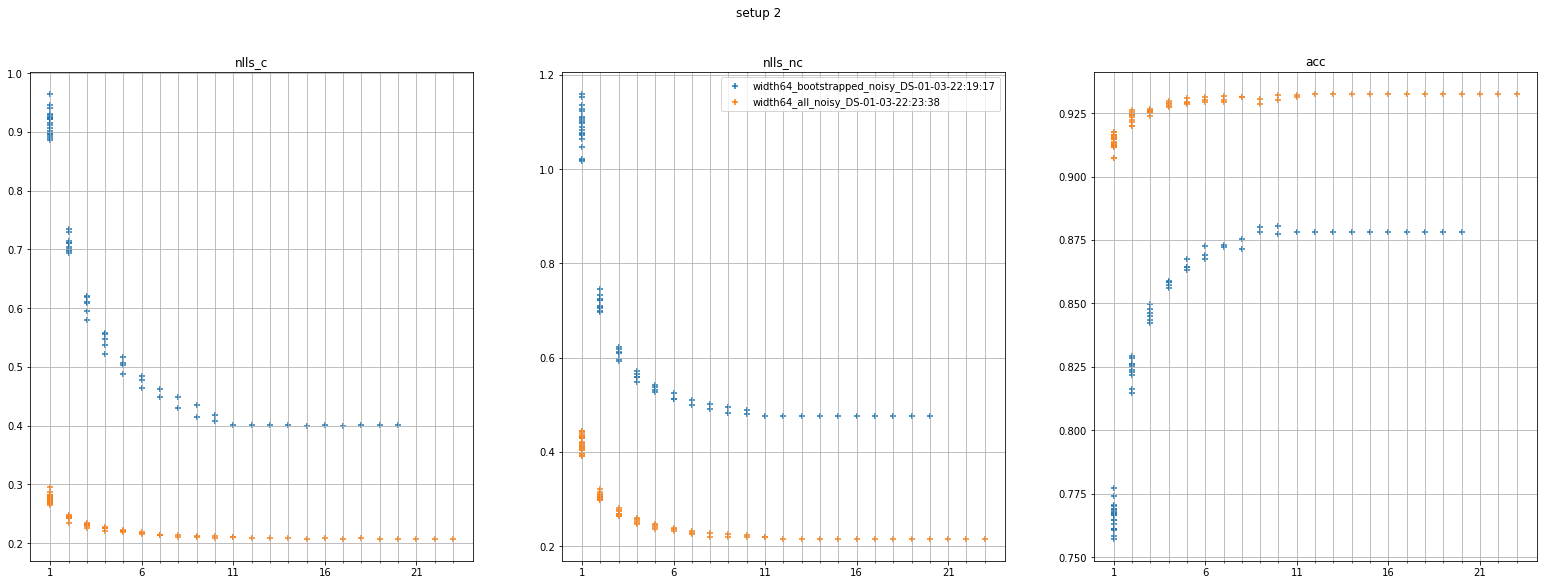

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (27, 9))

major_ticks = np.arange(1, max(len(nlls_c_or[boot_name]), len(nlls_c_or[all_name])) + 1, 5)
minor_ticks = np.arange(1, max(len(nlls_c_or[boot_name]), len(nlls_c_or[all_name])) + 1, 1)

a = ax1.scatter([j + 1 for j, sl in enumerate(nlls_c_or[boot_name]) for i in sl],
            [i for sl in nlls_c_or[boot_name] for i in sl], marker='+')
b = ax1.scatter([j + 1 for j, sl in enumerate(nlls_c_or[all_name]) for i in sl],
            [i for sl in nlls_c_or[all_name] for i in sl], marker='+')
ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='both')
ax1.set_title('nlls_c')
ax2.scatter([j + 1 for j, sl in enumerate(nlls_nc_or[boot_name]) for i in sl],
            [i for sl in nlls_nc_or[boot_name] for i in sl], marker='+', label=boot_name)
ax2.scatter([j + 1 for j, sl in enumerate(nlls_nc_or[all_name]) for i in sl],
            [i for sl in nlls_nc_or[all_name] for i in sl], marker='+', label=all_name)
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)
ax2.grid(which='both')
ax2.set_title('nlls_nc')
ax3.scatter([j + 1 for j, sl in enumerate(accs_global_or[boot_name]) for i in sl],
            [i for sl in accs_global_or[boot_name] for i in sl], marker='+')
ax3.scatter([j + 1 for j, sl in enumerate(accs_global_or[all_name]) for i in sl],
            [i for sl in accs_global_or[all_name] for i in sl], marker='+')
ax3.set_xticks(major_ticks)
ax3.set_xticks(minor_ticks, minor=True)
ax3.grid(which='both')
ax3.set_title('acc')


fig.suptitle(f'setup {setup}')

ax2.legend()
plt.show()

In [22]:
import os
from gather_nlls_module import ComputeNLLs

def softmax(x):
    e_x = np.exp(x - np.reshape(np.max(x,axis=1),(-1,1)))
    return e_x / np.reshape(e_x.sum(axis=1),(-1,1))

def compute_nlls(self, logdirs, model_name, num_classes, setting,\
                        plen=1, reverse_order=False, max_std=5, max_enslen=10**5):
    loaders, num_classes = data.loaders(
                "CIFAR%d"%num_classes,
                "./data/",
                128,
                1,
                "%s_noDA"%("VGG" if model_name == "VGG16" else "ResNet"),
                # True
            )
    targets = np.array(loaders["test"].dataset.targets)

    ll = 1 if not reverse_order else -1
    if not type(logdirs) == list:
        logdirs = [logdirs]
    preds = {}
    for logdir in logdirs:
        for i, p_folder in enumerate(sorted(os.listdir(logdir))):
            if not "ipynb" in p_folder and not "run" in p_folder:
                p_str = p_folder
                x = p_folder.find("_")
                # if x > 0:
                #     p = float(p_folder[plen:x])
                # else:
                p = p_folder[plen:]
                exp_folders = sorted(os.listdir(logdir+"/"+p_folder))
                if not p in preds:
                    preds[p] = []
                # for exp_folder in exp_folders:
                exp_folder = p_folder
                p_folder = ''
                if not "ipynb" in logdir+"/"+p_folder+"/"+exp_folder and\
                not "run" in logdir+"/"+p_folder+"/"+exp_folder and\
                not "skipsameseed" in exp_folder:
                    for f in sorted(os.listdir(logdir+"/"+p_folder+"/"+exp_folder))[::ll]:
                        if "predictions" in f:
                            fn = logdir+"/"+p_folder+"/"+exp_folder+"/"+f
                            if self.setup == 1:
                                ppp = softmax(np.float64(np.load(fn)))
                            else:
                                ppp = np.float64(np.load(fn))
                            acc = np.equal(np.argmax(ppp, axis=1), targets).mean()
                            if acc > 0.15:
                                preds[p].append(ppp[:, :, None] if self.setup==1\
                                                else ppp)
                            else:
                                print(exp_folder+"/"+f, "is bad!")
    return preds, targets

In [23]:
temps = np.arange(0.5, 3.2, 0.05)
logdirs = ["logs/oct/train.py-CIFAR10_VGG16/test_it",]

computer = ComputeNLLs(setup=setup, regime=regime, temps=temps)
preds, targets = compute_nlls(computer, logdirs, model, dataset, setting, plen=0, reverse_order=False, max_std=10**5, max_enslen=10**5)

Files already downloaded and verified
Using train (45000)
Using validation (5000)


In [25]:
max_enslen = 100
max_std = 5
nlls_c = []
nlls_nc = []
accs_global = []
temps_global = []
saturation_point = 11

ps = sorted(preds.keys())[::-1]
if setup == 1 or regime == "optimal":
    leng = min(len(preds[boot_name]), max_enslen, len(preds[all_name]) - saturation_point)

    for l in range(1, leng+1):
        print(l)
        accs, c_nlls, nc_nlls, temps = [], [], [], []
        count = min(len(preds[boot_name])//l, max_std)
        for j in range(count):
            ret = computer.get_ens_quality1_2o(preds[all_name][:saturation_point] + preds[boot_name][j*l:(j+1)*l], targets)
            if regime == "optimal":
                acc, nc_nll, c_nll, predictions, temps_ = ret
            else: # "grid"
                acc, c_nll, predictions = ret
            if acc > 0.15:
                accs.append(acc)
                c_nlls.append(c_nll)
                if regime == "optimal":
                    nc_nlls.append(nc_nll)
                    temps.append(temps_)

        nlls_c.append(c_nlls)
        nlls_nc.append(nc_nlls)
        accs_global.append(accs)
        temps_global.append(temps)

1
2
3
4
5
6
7
8
9
10
11
12


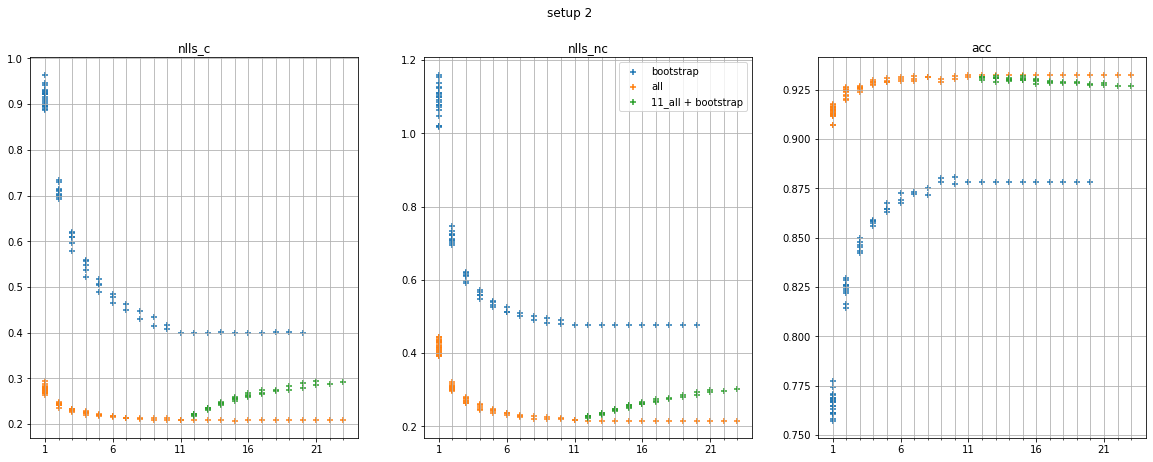

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))

major_ticks = np.arange(1, max(len(nlls_c_or[boot_name]), len(nlls_c_or[all_name])) + 1, 5)
minor_ticks = np.arange(1, max(len(nlls_c_or[boot_name]), len(nlls_c_or[all_name])) + 1, 1)

ax1.scatter([j + 1 for j, sl in enumerate(nlls_c_or[boot_name]) for i in sl],
            [i for sl in nlls_c_or[boot_name] for i in sl], marker='+')
ax1.scatter([j + 1 for j, sl in enumerate(nlls_c_or[all_name]) for i in sl],
            [i for sl in nlls_c_or[all_name] for i in sl], marker='+')
ax1.scatter([j + 1 + saturation_point for j, sl in enumerate(nlls_c) for i in sl],
            [i for sl in nlls_c for i in sl], marker='+')
ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='both')
ax1.set_title('nlls_c')
ax2.scatter([j + 1 for j, sl in enumerate(nlls_nc_or[boot_name]) for i in sl],
            [i for sl in nlls_nc_or[boot_name] for i in sl], marker='+', label='bootstrap')
ax2.scatter([j + 1 for j, sl in enumerate(nlls_nc_or[all_name]) for i in sl],
            [i for sl in nlls_nc_or[all_name] for i in sl], marker='+', label='all')
ax2.scatter([j + 1 + saturation_point for j, sl in enumerate(nlls_nc) for i in sl],
            [i for sl in nlls_nc for i in sl], marker='+', label=str(saturation_point) + '_all + bootstrap')
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)
ax2.grid(which='both')
ax2.set_title('nlls_nc')
ax3.scatter([j + 1 for j, sl in enumerate(accs_global_or[boot_name]) for i in sl],
            [i for sl in accs_global_or[boot_name] for i in sl], marker='+')
ax3.scatter([j + 1 for j, sl in enumerate(accs_global_or[all_name]) for i in sl],
            [i for sl in accs_global_or[all_name] for i in sl], marker='+')
ax3.scatter([j + 1 + saturation_point for j, sl in enumerate(accs_global) for i in sl],
            [i for sl in accs_global for i in sl], marker='+')
ax3.set_xticks(major_ticks)
ax3.set_xticks(minor_ticks, minor=True)
ax3.grid(which='both')
ax3.set_title('acc')

fig.suptitle(f'setup {setup}')

ax2.legend()
plt.show()